# Table of Contents

# 1. Setup 

# 2. Get Data

# 3. Create Datasets and DataLoaders 

# 4. Get and customize a pretrained model 

# 5. Train Model 

# 6. Evaluate the model by plotting loss curves 

# 7. Make predictions on images from the test set 

##### So far, the models that we made were not up to the standard that we wanted. 
##### To train a superb model, we need massive amouts of data and a large and complex model that is balanced right between the underfitting and overfitting paradigm. 
##### To bypass all of these tedious and sometimes impossible task, we can perform **transform learning**.

## What is Transfer Learning?

##### Transfer learning allows us to take the weights and biases from another model that has learned from a similar problem/task and use them for our own problem. 
##### For example, we can utilize the computer vision model, ImageNet and use them to perform our own image task. 

## Why use Transfer Learning?

##### There are mainly two benefits to using transfer learning. 
1) Can leverage an existing model proven to work on problems similar to our own.

2) Can leverage a working model which has already learned patterns on similar data to our own. This often results in achieving great results with less custom data. 

# 1. Setup

##### Let's import necessary libraries first.

In [1]:
import warnings
warnings.filterwarnings("ignore")

try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
/Users/kimhyunbin/Documents/Python/My own project (Python)/machinelearning/bin/pip3: line 2: /Users/kimhyunbin/Documents/My own project (Python)/machinelearning/bin/python3.10: No such file or directory
/Users/kimhyunbin/Documents/Python/My own project (Python)/machinelearning/bin/pip3: line 2: exec: /Users/kimhyunbin/Documents/My own project (Python)/machinelearning/bin/python3.10: cannot execute: No such file or directory
torch version: 2.0.0.dev20230212
torchvision version: 0.15.0.dev20230212


In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

##### Let's set up our device too.

In [3]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device('cpu')
device

device(type='mps')

# 2. Get Data

##### For the dataset we will be using today, we'll use the pizza_steak_sushi dataset provided from this course's Github.

In [4]:
import os
import zipfile

from pathlib import Path

import requests

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

data/pizza_steak_sushi directory exists.


##### Let's create paths to our training and test directories.

In [5]:
train_dir = image_path / "train"
test_dir = image_path / "test"

# 3. Create Datasets and DataLoaders

## Creating a transform for torchvision.models

##### With pretrained models, it's important that the custom data is prepared in the same way as the original training data has been prepared for the model.

In [6]:
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

##### This is playing according to the standards used by the pretrained models in torchvision.models.

In [7]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1379ba650>,
 ['pizza', 'steak', 'sushi'])

##### We can also perform this transformation automatically.

In [10]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [11]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [12]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1037fa2f0>,
 ['pizza', 'steak', 'sushi'])

In [13]:
img_custom, label_custom = next(iter(train_dataloader))

print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([32, 3, 224, 224]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


In [14]:
label_custom

tensor([0, 1, 2, 2, 0, 2, 0, 2, 0, 2, 0, 0, 2, 1, 2, 2, 2, 1, 2, 1, 0, 1, 0, 2,
        1, 2, 0, 2, 2, 1, 2, 0])

# 4. Get and customize a pretrained model 

##### We can now choose which pertrained model we want to be using. 
##### We can find pretrained classification models in torchvision.models.
##### For this scenario, we will be using the EfficientNet_B0 pretrained ImageNet weights.

In [66]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights 
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

##### Let's learn more about our model using torchinfo's summary() method.

In [67]:
summary(model = model, input_size = (32, 3, 224, 224))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [32, 1000]                --
├─Sequential: 1-1                                       [32, 1280, 7, 7]          --
│    └─Conv2dNormActivation: 2-1                        [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [32, 32, 112, 112]        864
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        64
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        --
│    └─Sequential: 2-2                                  [32, 16, 112, 112]        --
│    │    └─MBConv: 3-4                                 [32, 16, 112, 112]        1,448
│    └─Sequential: 2-3                                  [32, 24, 56, 56]          --
│    │    └─MBConv: 3-5                                 [32, 24, 56, 56]          6,004
│    │    └─MBConv: 3-6                              

##### The architecture is so huge it has to be shown in another text file but it basically has over 5 million parameters. 
##### The sheer number of parameters proves easily the complexity of the architecture.

## Freezing the base model and changing the output layer to suit our needs

##### The process of transfer learning usually goes as such: freeze some base layers and then adjust the output layers to suit our needs.
##### The complex base layers are where the model's power comes from.
##### However, the output layer needs to be altered in order to be able to correctly classify the classes we have in mind.

##### What **freezing** means in technical terms means to keep the pretrained weights of the model. 
##### We only wish to change those of the output layers.

In [68]:
for param in model.features.parameters():
    param.requires_grad = False

##### This is how we can have the feature extractor layer frozen.
##### Now, let's have our classifier layer made.

In [69]:
torch.manual_seed(42)

output_shape = len(class_names)

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape,
                    bias=True)).to(device)

summary(model, input_size=(32, 3, 224, 224,), verbose=0)

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [32, 3]                   --
├─Sequential: 1-1                                       [32, 1280, 7, 7]          --
│    └─Conv2dNormActivation: 2-1                        [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [32, 32, 112, 112]        (864)
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        (64)
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        --
│    └─Sequential: 2-2                                  [32, 16, 112, 112]        --
│    │    └─MBConv: 3-4                                 [32, 16, 112, 112]        (1,448)
│    └─Sequential: 2-3                                  [32, 24, 56, 56]          --
│    │    └─MBConv: 3-5                                 [32, 24, 56, 56]          (6,004)
│    │    └─MBConv: 3-6                      

# 5. Train Model

##### Now is the time to train our model.

In [70]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [71]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

 20%|██        | 1/5 [01:00<04:03, 60.79s/it]

Epoch: 1 | train_loss: 1.0940 | train_acc: 0.3867 | test_loss: 0.8911 | test_acc: 0.6714


 40%|████      | 2/5 [02:01<03:02, 60.71s/it]

Epoch: 2 | train_loss: 0.8777 | train_acc: 0.7773 | test_loss: 0.7915 | test_acc: 0.8352


 60%|██████    | 3/5 [03:02<02:01, 60.72s/it]

Epoch: 3 | train_loss: 0.7833 | train_acc: 0.7891 | test_loss: 0.7564 | test_acc: 0.8352


 80%|████████  | 4/5 [04:02<01:00, 60.70s/it]

Epoch: 4 | train_loss: 0.7070 | train_acc: 0.7422 | test_loss: 0.6481 | test_acc: 0.8759


100%|██████████| 5/5 [05:03<00:00, 60.70s/it]

Epoch: 5 | train_loss: 0.6143 | train_acc: 0.8086 | test_loss: 0.6318 | test_acc: 0.8665
[INFO] Total training time: 303.599 seconds


# 6. Evaluate the model by plotting loss curves 

##### Let's plot the loss curves to see what training looks like over time.

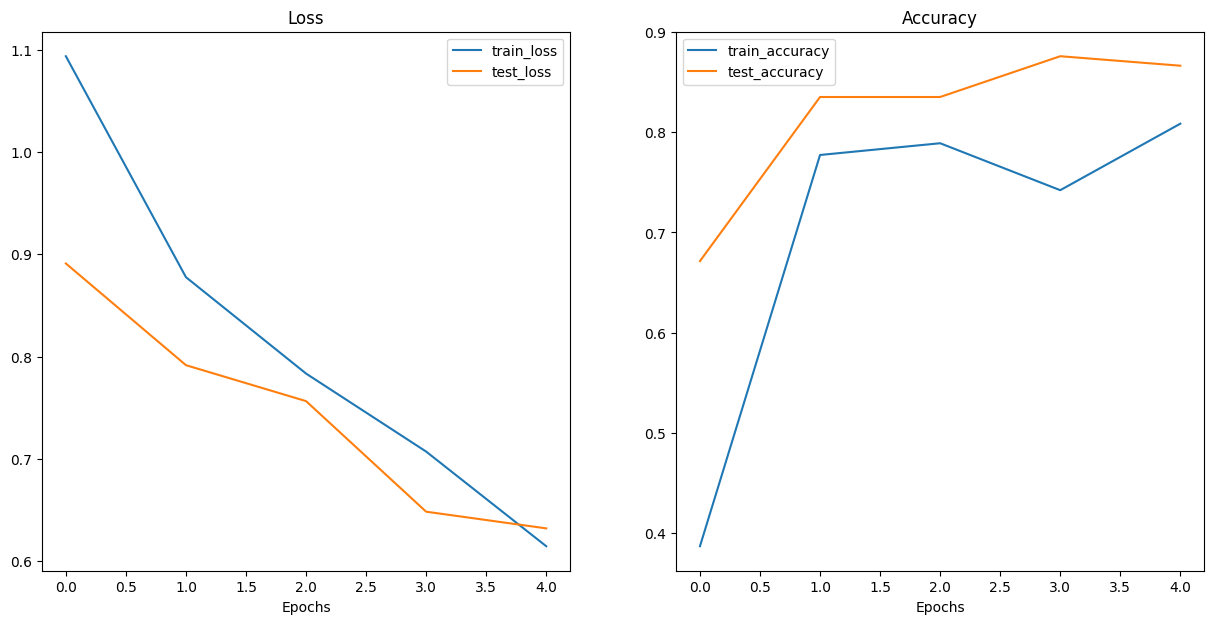

In [72]:
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

##### Now that is the power of transfer learning in a nutshell.
##### If you can notice, training for more epochs would show greater performance as currently, the model is showing signs of underfitting. 
##### Give this a shot!